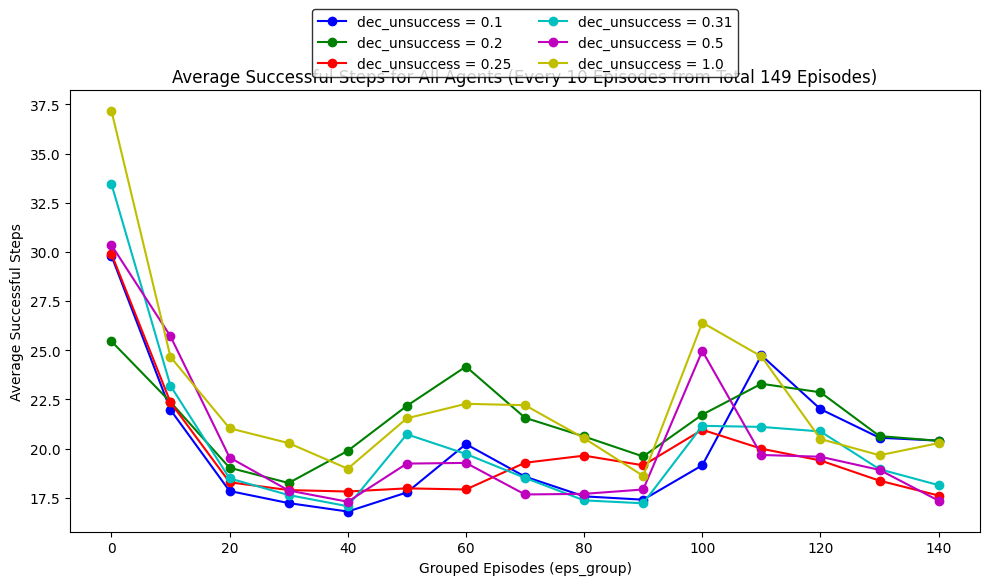

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Folder path containing CSV files in the current directory
folder_path = './d-t01/'

# Variable to control how many episodes to average together
episodes_per_average = 10

# Initialize an empty list to hold data from all files
all_data_frames = []

# Loop through all CSV files in the specified folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        # Load the data from the CSV file and append to the list
        df = pd.read_csv(file_path)
        df['filename'] = filename  # Add a filename column to keep track of source
        all_data_frames.append(df)

# If no CSV files are found, exit without generating the graph
if len(all_data_frames) == 0:
    print("No CSV files found in the specified folder.")
else:
    # Concatenate all data frames into a single data frame
    combined_data = pd.concat(all_data_frames, ignore_index=True)

    # Request user input for dec_success_nocase filtering
    dec_success_nocase_filter = float(input("Enter the value for dec_success_nocase (99 for no filter): "))

    # Apply filter for dec_success_nocase, if it's not 99
    if dec_success_nocase_filter != 99:
        combined_data = combined_data[combined_data['dec_success_nocase'] == dec_success_nocase_filter]

    # Create a new column for grouping episodes in batches
    combined_data['eps_group'] = (combined_data['eps'] // episodes_per_average) * episodes_per_average

    # Filter rows where eps_status == 1 (successful episodes)
    successful_df = combined_data[combined_data['eps_status'] == 1]

    # Group by 'eps_group' and 'dec_unsuccess', then calculate the average successful steps
    grouped_data = successful_df.groupby(['eps_group', 'dec_unsuccess'])['total_steps'].mean().reset_index()

    # Find unique values of 'dec_unsuccess' for coloring different lines
    unique_dec_unsuccess_values = grouped_data['dec_unsuccess'].unique()

    # Plot: Average Successful Steps Across All Episodes
    plt.figure(figsize=(10, 6))

    # Define a set of colors to use for different lines
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Plot the average successful steps for each `dec_unsuccess` value
    for i, dec_value in enumerate(unique_dec_unsuccess_values):
        # Filter the data for the current `dec_unsuccess` value
        data_filtered = grouped_data[grouped_data['dec_unsuccess'] == dec_value]
        # Plot the line for the current `dec_unsuccess` value
        plt.plot(data_filtered['eps_group'], data_filtered['total_steps'], label=f'dec_unsuccess = {dec_value}', color=colors[i % len(colors)], marker='o')

    # Set chart title and labels
    total_episodes = combined_data['eps'].nunique()
    plt.title(f"Average Successful Steps for All Agents (Every {episodes_per_average} Episodes from Total {total_episodes} Episodes)")
    plt.xlabel('Grouped Episodes (eps_group)')
    plt.ylabel('Average Successful Steps')

    # Place the legend above the plot area without overlapping, with a border
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=True, edgecolor='black')

    # Show the plot
    plt.tight_layout()
    plt.show()
